In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import torch
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from tqdm import trange, tqdm
from time import sleep
from algorithms import fit
from utils import latexify

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
latexify()

/Users/avajiang/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
# if torch.cuda.is_available():  
#     print('cuda available')
#     dev = "cuda:0" 
# else:  
#     dev = "cpu"  
# device = torch.device(dev)

# helper functions

In [3]:
def f_plot(Sx0,X,i):
    S,x0 = Sx0[:,0],Sx0[:,1]
    p = torch.square(S)
    quad = torch.square(torch.linalg.norm(S*X[:,i]))
    lin = torch.dot(X[:,i]*p,torch.sum(X[:,np.arange(m)!=i],axis=1) + x0)
    return quad + lin

In [4]:
def plot_results(val_losses, train_losses, param_updates, obj_vals, gamma_true, Sx0, X_untrained, X_trained, X_true, dist):
    epochs = len(val_losses)
    
    # loss by epoch
    plt.figure(figsize=(6,4))
    plt.plot(val_losses, 'k', label='val')
    plt.plot([np.mean(tl) for tl in train_losses], 'k--', label='train')
    plt.xlabel('epoch')
    plt.ylabel('log(loss)')
    plt.title('Validation and training loss by epoch')
    plt.yscale('log')
    plt.legend()
#     plt.show()
    plt.savefig('figures/pev/epoch_%s.jpg'%dist)
    
    # norm(gamma) updates by epoch
    plt.figure(figsize=(6,4))
    plt.plot(np.linalg.norm(param_updates.detach().numpy(),axis=1), 'k', label='$||\gamma||$')
    plt.hlines(np.linalg.norm(gamma_true), 0, epochs, colors='k', linestyles='dashed', label='$||\gamma||$ true')
    plt.xlabel('epoch')
    plt.ylabel('$||\gamma||$')
    plt.title('$||\gamma||$ updates by epoch')
    plt.legend()
#     plt.show()
    plt.savefig('figures/pev/gamma_%s.jpg'%dist)
    
    # gamma updates by epoch
    plt.figure(figsize=(6,4))
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
    for i in range(m):
        plt.plot(param_updates[:,i].detach().numpy(), color=colors[i], label='$||\gamma_%d||$'%i)
        plt.hlines(gamma_true[i], 0, epochs, colors=colors[i], linestyles='dashed', label='$||\gamma_%d||$ true'%i)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.title('$||\gamma||$ updates by epoch')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#     plt.show()
    plt.savefig('figures/pev/gamma_indiv_%s.jpg'%dist)
    
    # objective value by epoch
    plt.figure(figsize=(6,4))
    plt.plot(obj_vals, 'k', label='train')
    plt.hlines(f_plot(Sx0val[0,:,:],X_true[0,:,:],0), 0, epochs-1, colors='k', linestyles='dashed', label='true')
    plt.title('Objective value by epoch')
    plt.xlabel('epoch')
    plt.ylabel('objective value')
    plt.legend()
#     plt.show()
    plt.savefig('figures/pev/objval_%s.jpg'%dist)
    
    # untrained vs. trained vs. true
    plt.figure(figsize=(6,4))
    plt.plot(X_untrained[:,0].detach().numpy(), linestyle='dotted', label='untrained')
    plt.plot(X_trained[:,0].detach().numpy(), label='trained')
    plt.plot(X_true[0,:,0], '--', label='true')
    plt.title('$x_1$ over time')
    plt.xlabel('$t$')
    plt.ylabel('$x_1$')
    plt.legend()
#     plt.show()
    plt.savefig('figures/pev/x_%s.jpg'%dist)

# setup

In [5]:
h = 100   # time horizon
m = 5     # number of vehicles

In [6]:
def constr(x,i,x0,gamma):
    x_i = x[:,i]
    constraints = None
    if i==0:
        constraints = [x_i == x0]
    else:
        constraints = [cp.sum(x_i) == gamma[i-1],
                       x_i >= 0,
                       x_i <= 1]
    return constraints

# method 1: non-distributed

In [7]:
x = cp.Variable((h,m+1))
s = cp.Variable(h)
Sx0 = cp.Parameter((h,2))
gamma = cp.Parameter(m)

objective = cp.sum_squares(cp.multiply(Sx0[:,0],s))
constraints = [c for i in range(m+1) for c in constr(x,i,Sx0[:,1],gamma)] + [s == cp.sum(x,axis=1)]
prob = cp.Problem(cp.Minimize(objective), constraints)

layer = CvxpyLayer(prob, [Sx0,gamma], [x,s])

## forward pass

In [8]:
# get data
def get_data_nd(N,gamma):
    p,x0 = torch.rand(N,h),torch.rand(N,h)
    S = torch.sqrt(p)
    Sx0 = torch.dstack((S,x0))
    gamma = gamma.repeat(N,1)
    x,_ = layer(Sx0,gamma,solver_args={"solve_method":'ECOS'})
    return Sx0,x

gamma_true = torch.rand(m)*10
print(gamma_true)

Sx0,X_nd = get_data_nd(100, gamma_true)
Sx0val,Xval_nd = get_data_nd(50, gamma_true)

tensor([4.9626, 7.6822, 0.8848, 1.3203, 3.0742])


## backward pass

In [9]:
# mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
gamma = torch.rand(m)
print(gamma)
gamma.requires_grad_(True)

def loss_nd(Sx0,x,gamma):
    N = Sx0.shape[0]
    gamma = gamma.repeat(N,1)
    return l1_loss(layer(Sx0,gamma,solver_args={"solve_method":'ECOS'})[0],x)

tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074])


In [10]:
epochs = 30
val_losses_nd, train_losses_nd, param_updates_nd = fit(lambda Sx0,X: loss_nd(Sx0,X,gamma), [gamma], Sx0, X_nd, Sx0val, Xval_nd,
                                                       opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                                                       batch_size=20, epochs=epochs, verbose=True)

001 | 0.02702
batch 001 / 005 | 0.02707
batch 002 / 005 | 0.02673
batch 003 / 005 | 0.02636
batch 004 / 005 | 0.02600
batch 005 / 005 | 0.02566
002 | 0.02365
batch 001 / 005 | 0.02369
batch 002 / 005 | 0.02338
batch 003 / 005 | 0.02300
batch 004 / 005 | 0.02287
batch 005 / 005 | 0.02263
003 | 0.02087
batch 001 / 005 | 0.02115
batch 002 / 005 | 0.02069
batch 003 / 005 | 0.02032
batch 004 / 005 | 0.02012
batch 005 / 005 | 0.01991
004 | 0.01819
batch 001 / 005 | 0.01828
batch 002 / 005 | 0.01793
batch 003 / 005 | 0.01762
batch 004 / 005 | 0.01746
batch 005 / 005 | 0.01728
005 | 0.01566
batch 001 / 005 | 0.01580
batch 002 / 005 | 0.01572
batch 003 / 005 | 0.01568
batch 004 / 005 | 0.01531
batch 005 / 005 | 0.01503
006 | 0.01356
batch 001 / 005 | 0.01348
batch 002 / 005 | 0.01358
batch 003 / 005 | 0.01334
batch 004 / 005 | 0.01311
batch 005 / 005 | 0.01295
007 | 0.01155
batch 001 / 005 | 0.01173
batch 002 / 005 | 0.01142
batch 003 / 005 | 0.01129
batch 004 / 005 | 0.01120
batch 005 / 005 | 

In [11]:
obj_vals_nd = np.zeros(epochs)
for epoch in range(epochs):
    gamma_temp = param_updates_nd[epoch,:]
    X_temp = layer(Sx0val,gamma_temp,solver_args={"solve_method":'ECOS'})[0][0,:,1:]
    obj_vals_nd[epoch] = f_plot(Sx0val[0,:,:],X_temp,0)
    
X_untrained_nd = layer(Sx0val,param_updates_nd[0,:],solver_args={"solve_method":'ECOS'})[0][0,:,1:]
X_trained_nd = layer(Sx0val,param_updates_nd[-1,:],solver_args={"solve_method":'ECOS'})[0][0,:,1:]

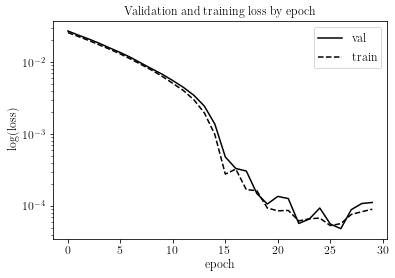

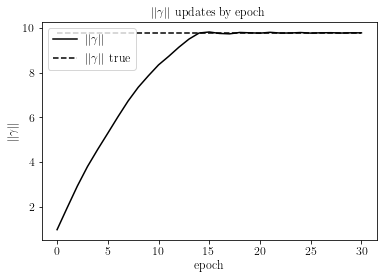

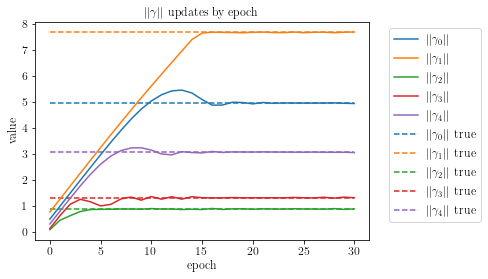

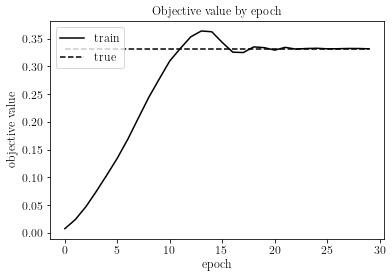

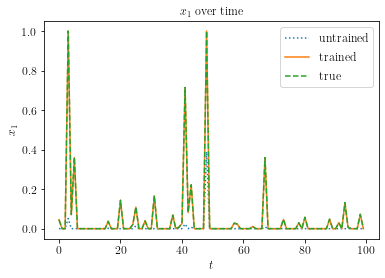

In [12]:
plot_results(val_losses_nd, train_losses_nd, param_updates_nd, obj_vals_nd, gamma_true, Sx0val, X_untrained_nd, X_trained_nd, Xval_nd[:,:,1:], 'nd')

# method 2: distributed

In [13]:
QUIET    = 1
MAX_ITER = 15
rho = 1

In [14]:
def constr_dist(x,i,gamma):
    x_i = x[i]
    constraints = [cp.sum(x_i) == gamma[i],
                   x_i >= 0,
                   x_i <= 1]
    return constraints

def f(x,S,pz,i):
    quad = cp.sum_squares(cp.multiply(S,x[i]))
    lin = pz.T@x[i]
    return quad + lin

def g(zbar,S_x0,px0):
    lin = px0.T@(m*zbar)
    return S_x0 + lin

In [15]:
# set up x-update step
x = [cp.Variable(h)]*m
v = cp.Parameter(h)
gamma = cp.Parameter(m)
S = cp.Parameter(h)
pz = cp.Parameter(h)

obj_x = [f(x,S,pz,i) + (rho/2)*cp.sum_squares(x[i]-v) for i in range(m)]
prox_x = [cp.Problem(cp.Minimize(obj_x[i]), constr_dist(x,i,gamma)) for i in range(m)]
layers_x = [CvxpyLayer(prox_x[i],[v,gamma,S,pz],[x[i]]) for i in range(m)]

In [16]:
# set up z-update step
zbar = cp.Variable(h)
S_x0 = cp.Parameter()
abar = cp.Parameter(h)
px0 = cp.Parameter(h)

obj_z = g(zbar,S_x0,px0) + (m*rho/2)*cp.sum_squares(zbar-abar)
prox_z = cp.Problem(cp.Minimize(obj_z))
layer_z = CvxpyLayer(prox_z,[abar,S_x0,px0],[zbar])

In [17]:
def admm(Sx0,gamma,layers_x,layer_z):
    N = Sx0.shape[0]
    S,x0 = Sx0[:,:,0],Sx0[:,:,1]
    p = torch.square(S)
    
    X = torch.zeros((N,h,m))
    Z = torch.zeros((N,h,m))
    Zbar = torch.zeros((N,h))
    U = torch.zeros((N,h))
    r_norm = torch.zeros((N,MAX_ITER))
    s_norm = torch.zeros((N,MAX_ITER))
    
    for k in tqdm(range(MAX_ITER)):
        # x-update
        for i in range(m):
            v = X[:,:,i] - torch.mean(X,axis=2) + Zbar - U
            pz = p*(torch.sum(Z[:,:,np.arange(m)!=i],axis=2) + x0)
            X[:,:,i] = layers_x[i](v,gamma,S,pz,solver_args={"solve_method":'ECOS'})[0]
            
        Xbar = torch.mean(X,axis=2)
            
        # z-update
        abar = U + Xbar
        S_x0 = torch.square(torch.norm(S*x0,dim=1))
        px0 = p*x0
        Zbar = layer_z(abar,S_x0,px0,solver_args={"solve_method":'ECOS'})[0]
        Z_old = Z
        Z = Zbar.repeat(m,1,1).permute(1,2,0) + X - Xbar.repeat(m,1,1).permute(1,2,0)

        
        # u-update
        U  += Xbar - Zbar
        
        # progress tracking
        r_norm[:,k] = torch.flatten(torch.linalg.norm(Xbar-Zbar,dim=1))
        s_norm[:,k] = torch.flatten(torch.linalg.norm(rho*(torch.reshape(Z_old,(N,h*m))-torch.reshape(Z,(N,h*m))),dim=1))
        

    return X,r_norm,s_norm

## forward pass

In [18]:
def get_data_d(N, Sx0, gamma):
    gamma = gamma.repeat(N,1)
    X,r_norm,s_norm = admm(Sx0,gamma,layers_x,layer_z)
    return X,r_norm,s_norm

X_d,r_norm,s_norm = get_data_d(100, Sx0, gamma_true)
Xval_d,r_normval,s_normval = get_data_d(50, Sx0val, gamma_true)

100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


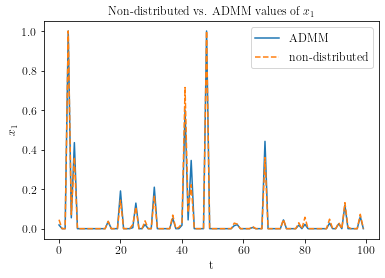

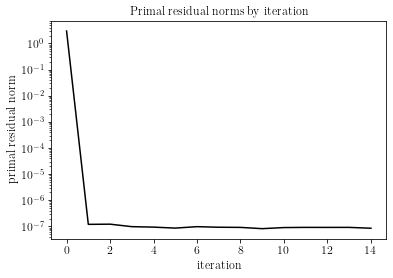

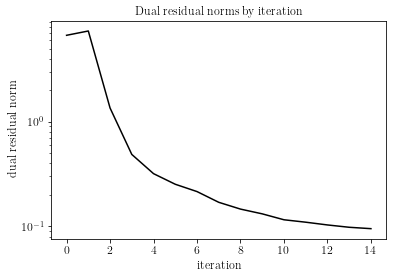

In [19]:
# compare results
plt.figure(figsize=(6,4))
plt.plot(Xval_d[0,:,0], label = 'ADMM')
plt.plot(Xval_nd[0,:,1], '--', label = 'non-distributed')
plt.legend()
plt.title('Non-distributed vs. ADMM values of $x_1$')
plt.xlabel('t')
plt.ylabel('$x_1$')
# plt.show()
plt.savefig('figures/pev/fp_comp.jpg')

# primal residual tracking
plt.figure(figsize=(6,4))
plt.plot(r_norm[0,:], 'k')
plt.yscale('log')
plt.title('Primal residual norms by iteration')
plt.xlabel('iteration')
plt.ylabel('primal residual norm')
# plt.show()
plt.savefig('figures/pev/fp_rnorm.jpg')

# dual residual tracking
plt.figure(figsize=(6,4))
plt.plot(s_norm[0,:], 'k')
plt.yscale('log')
plt.title('Dual residual norms by iteration')
plt.xlabel('iteration')
plt.ylabel('dual residual norm')
# plt.show()
plt.savefig('figures/pev/fp_snorm.jpg')

# backward pass

In [20]:
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
gamma = torch.rand(m)
print(gamma)
gamma.requires_grad_(True)

def loss_d(Sx0,x,gamma):
    N = Sx0.shape[0]
    gamma = gamma.repeat(N,1)
    return l1_loss(admm(Sx0,gamma,layers_x,layer_z)[0],x)

tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074])


In [21]:
val_losses_d, train_losses_d, param_updates_d = fit(lambda Sx0,X: loss_d(Sx0,X,gamma), [gamma], Sx0, X_d, Sx0val, Xval_d,
                                                    opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                                                    batch_size=20, epochs=epochs, verbose=True)

  0%|          | 0/15 [00:00<?, ?it/s]

001 | 0.03227


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.03228


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.03179


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.03131


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.03086


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.03041


  0%|          | 0/15 [00:00<?, ?it/s]

002 | 0.02778


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.02779


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.02746


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.02711


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.02677


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.02637


  0%|          | 0/15 [00:00<?, ?it/s]

003 | 0.02425


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.02450


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.02408


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.02376


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.02337


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.02308


  0%|          | 0/15 [00:00<?, ?it/s]

004 | 0.02112


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.02116


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.02092


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.02059


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.02031


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.02000


  0%|          | 0/15 [00:00<?, ?it/s]

005 | 0.01809


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01800


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01782


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01757


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01727


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01704


  0%|          | 0/15 [00:00<?, ?it/s]

006 | 0.01519


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01564


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01515


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01483


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01457


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01427


  0%|          | 0/15 [00:00<?, ?it/s]

007 | 0.01259


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01289


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01268


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01238


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.01216


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.01190


  0%|          | 0/15 [00:00<?, ?it/s]

008 | 0.01036


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.01065


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.01028


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.01004


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00976


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00954


  0%|          | 0/15 [00:00<?, ?it/s]

009 | 0.00787


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00809


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00780


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00756


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00731


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00712


  0%|          | 0/15 [00:00<?, ?it/s]

010 | 0.00586


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00604


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00592


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00581


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00568


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00556


  0%|          | 0/15 [00:00<?, ?it/s]

011 | 0.00485


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00498


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00485


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00475


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00463


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00451


  0%|          | 0/15 [00:00<?, ?it/s]

012 | 0.00371


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00375


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00359


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00344


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00329


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00313


  0%|          | 0/15 [00:00<?, ?it/s]

013 | 0.00217


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00221


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00205


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00189


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00173


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00156


  0%|          | 0/15 [00:00<?, ?it/s]

014 | 0.00065


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00067


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00057


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00048


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00049


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00051
new lr: 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

015 | 0.00077


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00079


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00073


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00063


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00055


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00049


  0%|          | 0/15 [00:00<?, ?it/s]

016 | 0.00013


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00013


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00014


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00017


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00018


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00018


  0%|          | 0/15 [00:00<?, ?it/s]

017 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00014


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00012


  0%|          | 0/15 [00:00<?, ?it/s]

018 | 0.00017


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00018


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00016


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00015


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00014


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00012


  0%|          | 0/15 [00:00<?, ?it/s]

019 | 0.00010


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00012


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00012


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00012


  0%|          | 0/15 [00:00<?, ?it/s]

020 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00011


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

021 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

022 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

023 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

024 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

025 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

026 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

027 | 0.00008


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

028 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

029 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00007


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00005


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00006


  0%|          | 0/15 [00:00<?, ?it/s]

batch 005 / 005 | 0.00006
new lr: 0.025


  0%|          | 0/15 [00:00<?, ?it/s]

030 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  0%|          | 0/15 [00:00<?, ?it/s]

batch 002 / 005 | 0.00013


  0%|          | 0/15 [00:00<?, ?it/s]

batch 003 / 005 | 0.00013


  0%|          | 0/15 [00:00<?, ?it/s]

batch 004 / 005 | 0.00011


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


batch 005 / 005 | 0.00010


In [22]:
N = Sx0val.shape[0]
obj_vals_d = np.zeros(epochs)
for epoch in range(epochs):
    gamma_temp = param_updates_d[epoch,:]
    X_temp = admm(Sx0val,gamma_temp.repeat(N,1),layers_x,layer_z)[0][0,:,:]
    obj_vals_d[epoch] = f_plot(Sx0val[0,:,:],X_temp,0)

X_untrained_d = admm(Sx0val,param_updates_d[0,:].repeat(N,1),layers_x,layer_z)[0][0,:,:]
X_trained_d = admm(Sx0val,param_updates_d[-1,:],layers_x,layer_z)[0][0,:,:]

100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


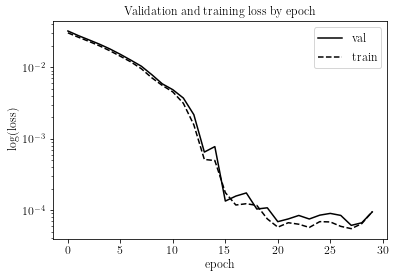

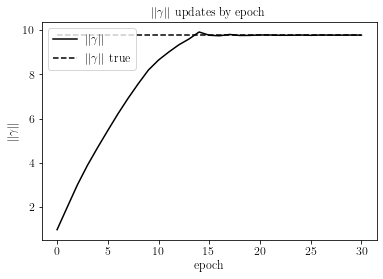

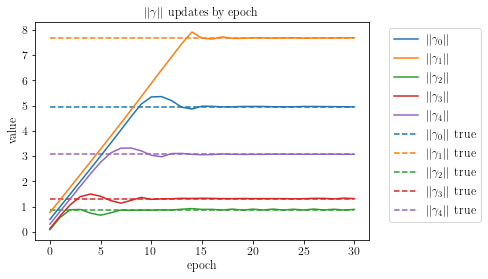

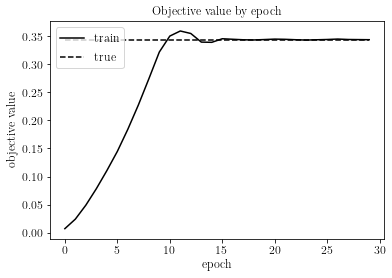

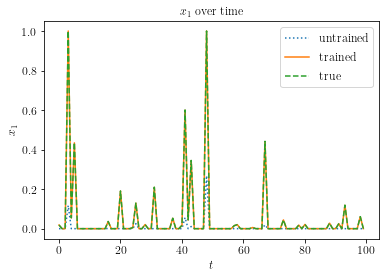

In [23]:
plot_results(val_losses_d, train_losses_d, param_updates_d, obj_vals_d, gamma_true, Sx0val, X_untrained_d, X_trained_d, Xval_d, 'd')